# Exercise 03 - Due Monday, November 9 at 1 pm

*Objectives*: Use Spark to process and perform basic analysis on non-relational data, including its DataFrame and SQL interfaces.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with Python code, SQL queries, shell commands, and markdown cells.  The notebook itself should be completely reproducible (using AWS EC2 instance based on the provided AMI) from start to finish; another person should be able to use the code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking when appropriate.

*Deadline*: Monday, November 9, 1 pm. 

## Part 1 - Setup

Begin by setting up Spark and fetching the project data.  

**Note**: you may want to use a larger EC2 instance type than normal.  This project was prepared using a `t2.xlarge` instance.  Just remember that the larger the instance, the higher the per-hour charge, so be sure to remember to shut your instance down when you're done, as always.

### About the data

We will use JSON data from Twitter; we saw an example of this in class.  It should parse cleanly, allowing you to focus on analysis.

This data was gathered using GWU Libraries' [Social Feed Manager](http://sfm.library.gwu.edu/) application during a recent game of the MLB World Series featuring the Los Angeles Dodgers and Houston Astros.  This first file tells you a little bit about how it was gathered:

In [1]:
!wget https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611-README.txt

--2020-11-02 20:57:50--  https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611-README.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1920 (1.9K) [text/plain]
Saving to: ‘9670f3399f774789b7c3e18975d25611-README.txt’

9670f3399f774789b7c 100%[===================>]   1.88K  --.-KB/s    in 0s      

2020-11-02 20:57:50 (20.2 MB/s) - ‘9670f3399f774789b7c3e18975d25611-README.txt’ saved [1920/1920]



In [2]:
!cat 9670f3399f774789b7c3e18975d25611-README.txt

This is an export created with Social Feed Manager.

EXPORT INFORMATION
Selected seeds: All seeds
Export id: 9670f3399f774789b7c3e18975d25611
Export type: twitter_filter
Format: Full JSON
Export completed:  Oct. 30, 2017, 11:21:04 p.m. EDT
Deduplicate: No

COLLECTION INFORMATION
Collection name: test set for world series
Collection id: 34e3f7460b5c4df09d64a1e61fd81238
Collection set: mlb-test (collection set id d6e8c27b1bc942e78790aa55a82b3a7a)
Harvest type: Twitter filter
Collection description: running for just one hour, just for fun.

Harvest options:
Media: No
Web resources: No

Seeds:
* Track: dodgers,astros - Active

Change log:

Change to test set for world series (collection) on Oct. 30, 2017, 10:59:56 p.m. EDT by dchud:
* is_active: "True" changed to "False"

Change to test set for world series (collection) on Oct. 30, 2017, 10:58:51 p.m. EDT by dchud:
* is_on: "True" changed to "False"

Change to test set for world series (collection) on Oct. 29, 2017, 8:01:24 p.m. EDT by dch

The most important pieces in that metadata are:

 * It tracked tweets that mentioned "dodgers" or "astros".  Every item in this set should refer to one or the other, or both.
 * This data was not deduplicated; we may see individual items more than once.
 * Data was collected between October 29 and October 30.  Game 5 of the Series was played during this time.
 
You should not need to know anything about baseball to complete this assignment.

**Please note**: sometimes social media data contains offensive material.  This data set has not been filtered; if you do come across something inappropriate, please do your best to ignore it if you can.

## Fetch the data

The following files are available:

 * https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_003.json
 * https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_004.json
 * https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_005.json
 * https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_006.json
 
### Q1.1 - Select at least one and obtain it using `wget`.  Verify the file sizes using the command line.

Each file should contain exactly 100,000 tweets.  

*Note*: you are only required to use one of these files, but you may use more than one.  It will be easier to process more data if you use a larger EC2 instance type, as suggested above.  Use the exact same set of files throughout the assignment.

**Answer**

In [3]:
!wget https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_003.json

--2020-11-02 21:01:32--  https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_003.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595711407 (568M) [application/json]
Saving to: ‘9670f3399f774789b7c3e18975d25611_003.json’

9670f3399f774789b7c 100%[===================>] 568.11M  25.9MB/s    in 31s     

2020-11-02 21:02:04 (18.2 MB/s) - ‘9670f3399f774789b7c3e18975d25611_003.json’ saved [595711407/595711407]



__Here I decide to use the first json file throughout my whole assignment https://s3.amazonaws.com/2017-dmfa/project-3/9670f3399f774789b7c3e18975d25611_003.json using wget function.__

For your reference, here is the text of one Tweet, randomly selected from one of these files.  You might wish to study its structure and refer to it later.

In [4]:
!cat *.json | shuf -n 1 > example-tweet.json

In [5]:
import json
print(json.dumps(json.load(open("example-tweet.json")), indent=2))

{
  "quote_count": 0,
  "contributors": null,
  "truncated": false,
  "text": "RT @astros: Nobody said it was going to be easy.\n\nWe're tied at 12 heading to the bottom of the 9th. These two guys coming up.\u2026 ",
  "is_quote_status": false,
  "in_reply_to_status_id": null,
  "reply_count": 0,
  "id": 924871857119121408,
  "favorite_count": 0,
  "entities": {
    "user_mentions": [
      {
        "id": 52803520,
        "indices": [
          3,
          10
        ],
        "id_str": "52803520",
        "screen_name": "astros",
        "name": "Houston Astros"
      }
    ],
    "symbols": [],
    "hashtags": [],
    "urls": []
  },
  "retweeted": false,
  "coordinates": null,
  "timestamp_ms": "1509341608682",
  "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
  "in_reply_to_screen_name": null,
  "id_str": "924871857119121408",
  "retweet_count": 0,
  "in_reply_to_user_id": null,
  "favorited": false,
  "retweeted_status": {
  

You can find several key elements in this example; the text, time, and language of the tweet, whether it was a reply to another user, the user's screen name along with their primary language and other account information like creation date, follower/friend/tweet counts, and perhaps their location.  If there are hashtags, user mentions, or urls present in their tweet, they will be present in the `entities` section; these are not present in every tweet.  If this is a retweet, you will see the original tweet and its information nested within.

### Q1.2 - Start up Spark, and verify the file sizes.

We will use our normal startup sequence here:

In [1]:
import os

In [2]:
os.environ['SPARK_HOME'] = '/usr/local/lib/spark'

In [3]:
import findspark

In [4]:
findspark.init()

In [5]:
from pyspark import SparkContext

In [6]:
spark = SparkContext(appName='project-03')

In [9]:
spark

<SparkContext master=local[*] appName=project-03>

In [7]:
from pyspark import SQLContext

In [8]:
sqlc = SQLContext(spark)

In [9]:
sqlc

In [9]:
tweets = sqlc.read.json("9670f3399f774789b7c3e18975d25611_*.json")

Verify that Spark has loaded the same number of tweets you saw before:

**Answer**

In [18]:
!wc -l 9670f3399f774789b7c3e18975d25611_*.json

100000 9670f3399f774789b7c3e18975d25611_003.json


In [19]:
tweets.count()

100000

We could see that when I directly read lines from the original jason

## Part 2 - Comparing DataFrames and Spark SQL

For the next three questions, we will look at operations using both DataFrames and SQL queries. Note that `tweets` is already a DataFrame:

To issue SQL queries, we need to register a table based on `tweets`:

In [10]:
tweets.createOrReplaceTempView("tweets")

### Q2.1 - Which 10 languages are most commonly used in tweets?  Verify your result by executing it with both the dataframe and with SQL.

Hint: for the dataframe, use `groupBy`, `count`, and `orderBy`.  See the documentation at https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html for details on these and other functions.

**Answer**
+ We could see that both the dataframe and sql contain the same result

In [16]:
tweets.groupby('lang').count().orderBy('count',ascending = False).show(10)

+----+-----+
|lang|count|
+----+-----+
|  en|88987|
|  es| 6825|
| und| 3058|
|  in|  210|
|  fr|  181|
|  pt|  133|
|  nl|   89|
|  ht|   83|
|  ja|   81|
|  tl|   77|
+----+-----+
only showing top 10 rows



In [13]:
sqlc.sql("""
    SELECT lang, COUNT(lang) AS count
    FROM tweets
    GROUP BY lang
    ORDER BY count DESC
""").show(10)

+----+-----+
|lang|count|
+----+-----+
|  en|88987|
|  es| 6825|
| und| 3058|
|  in|  210|
|  fr|  181|
|  pt|  133|
|  nl|   89|
|  ht|   83|
|  ja|   81|
|  tl|   77|
+----+-----+
only showing top 10 rows



### Q2.2 - Which 10 time zones are most common among users?  Verify your result with both the dataframe and SQL.

*Note*: for this question, you may leave NULL values present in your results, as a way to help you understand what data is present and what is missing.

**Answer**

Since null is included in this dataframe, in order to show the top 10 time zones, I show 11 rows which includes top 10 countries and null. We can see that both the dataframe and sql show tha same results.

In [15]:
tweets.groupby('user.time_zone').count().orderBy('count',ascending = False).show(11)

+--------------------+-----+
|           time_zone|count|
+--------------------+-----+
|                null|42239|
|Central Time (US ...|17436|
|Pacific Time (US ...|17097|
|Eastern Time (US ...| 8664|
|             Arizona| 2490|
|Mountain Time (US...| 2475|
|Atlantic Time (Ca...| 1048|
|             Caracas| 1006|
|              Hawaii|  821|
|         Mexico City|  793|
|               Quito|  787|
+--------------------+-----+
only showing top 11 rows



In [14]:
sqlc.sql("""
    SELECT user.time_zone, COUNT(user.time_zone)  AS count
    FROM tweets
    GROUP BY user.time_zone
    ORDER BY count DESC
""").show(10)

+--------------------+-----+
|           time_zone|count|
+--------------------+-----+
|Central Time (US ...|17436|
|Pacific Time (US ...|17097|
|Eastern Time (US ...| 8664|
|             Arizona| 2490|
|Mountain Time (US...| 2475|
|Atlantic Time (Ca...| 1048|
|             Caracas| 1006|
|              Hawaii|  821|
|         Mexico City|  793|
|               Quito|  787|
+--------------------+-----+
only showing top 10 rows



### Q2.3 - How many tweets mention the Dodgers?  How many mention the Astros?  How many mention both?

You may use either the dataframe or SQL to answer.  Explain why you have chosen that approach.

Hint:  you will want to look at the value of the `text` field.

**Answer**

In [33]:
from pyspark.sql.functions import lower
tweets.filter(lower(tweets['text']).contains('dodgers')).count()

33114

In [20]:
# consider both upper case and lower case
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE lower(text) LIKE "%dodgers%"
""").show()

+--------+
|count(1)|
+--------+
|   33114|
+--------+



In [34]:
# First letter uppercase
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE text LIKE "%Dodgers%"
""").show()

+--------+
|count(1)|
+--------+
|   27822|
+--------+



I choose to use sql to solve this problem. For the convenience of explaination, I provide both solution for dodgers:
+ Since sql and sparks are case sensitive, in order to find the tweets that mention the team names, I think it is more reasonable to consider both upper and lower cases for spelling. Therefore, I will have to lower the case first. SQL has built in lower function. While as for dataframe, I have to import the function first before using it. Therefore, I think sql is more convenient in this problem.
+ In the questions, it is not specified about the case. That's why I also provide the counts which only the first letter of the team name is uppercased (Astros, Dodgers), just like the format in the question.

As for the result of this questions, if ignoring the case of mentioning the teamname:
+ Dodgers has been mention for 33114 times.
+ Astros has been mention for 70149 times.
+ Both are mentioned for 13962 times.

If we directly take it from the questions, just consider the case where the first letter is uppercase (Astros, Dodgers):
+ Dodgers has been mentioned for 27822 times.
+ Astros has been mentioned for 34162 times.
+ Both are mentioned for 10421 times.

__Astros__

In [28]:
# ignore case - Astros
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE lower(text) LIKE "%astros%"
""").show()

+--------+
|count(1)|
+--------+
|   70149|
+--------+



In [35]:
# only first letter uppercase as asked in the question - Astros
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE text LIKE "%Astros%"
""").show()

+--------+
|count(1)|
+--------+
|   34162|
+--------+



__Both Astros and Dodgers__

In [12]:
# ignore case - both
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE lower(text) LIKE "%astros%"
    AND lower(text) LIKE "%dodgers%"
""").show()

# only first letter uppercase as asked in the question - both
sqlc.sql("""
    SELECT COUNT(*)
    From tweets
    WHERE text LIKE "%Astros%" 
    AND text LIKE "%Dodgers%"
""").show()

+--------+
|count(1)|
+--------+
|   13962|
+--------+

+--------+
|count(1)|
+--------+
|   10421|
+--------+



## Part 3 - More complex queries

For this section, you may choose to use dataframe queries or SQL.  If you wish, you may verify results by using both, as in Part 2, but this is not required for this section.

### Q3.1 - Team mentions by location

In which users' locations are the Astros and the Dodgers being mentioned the most?  Consider each team separately, one at a time.  Discuss your findings.

Hint:  you may use either the time zones or user-specified locations for this question.

**Answer**

**Dogders:**
+ Whether or not we considering the case of spelling the team name, the top location is the same.
+ We could see from the dataframe result that most of the tweets that contain Dogders does not have time_zone.
+ If we ignore the null rows, the top 1 time zone is Pacific Time of United States which appear 8072 times. If first letter uppercase, 6650 times. This result is reasonable to me because Dodgers is a Los Angeles Team and Los Angeles uses Pacific Standard Time.

In [30]:
# ignore case
tweets.filter(lower(tweets['text']).contains('dodgers')) \
    .groupby('user.time_zone') \
    .count() \
    .orderBy('count',ascending = False).show(2, False)

+--------------------------+-----+
|time_zone                 |count|
+--------------------------+-----+
|null                      |13806|
|Pacific Time (US & Canada)|8072 |
+--------------------------+-----+
only showing top 2 rows



In [36]:
# first letter upper case, Dogders
tweets.filter(tweets['text'].contains('Dodgers')) \
    .groupby('user.time_zone') \
    .count() \
    .orderBy('count',ascending = False).show(2, False)

+--------------------------+-----+
|time_zone                 |count|
+--------------------------+-----+
|null                      |11315|
|Pacific Time (US & Canada)|6650 |
+--------------------------+-----+
only showing top 2 rows



**Astros:**
+  Whether or not we considering the case of spelling the team name, the top location is the same.
+ Similar like previous result, we could see that most of the Astroc contained tweets do not have time_zone.
+ If we ignore the null, Central Time has the highest count, 14183, for Astroc. If first letter upper case, 6286 times. Houston is the hometown for Astroc which uses Central Time. Therefore this result makes sense.

In [32]:
# ignore case
tweets.filter(lower(tweets['text']).contains('astros')) \
    .groupby('user.time_zone') \
    .count() \
    .orderBy('count',ascending = False).show(2, False)

+--------------------------+-----+
|time_zone                 |count|
+--------------------------+-----+
|null                      |29896|
|Central Time (US & Canada)|14183|
+--------------------------+-----+
only showing top 2 rows



In [38]:
# first letter upper case, Astro
tweets.filter(tweets['text'].contains('Astros')) \
    .groupby('user.time_zone') \
    .count() \
    .orderBy('count',ascending = False).show(2, False)

+--------------------------+-----+
|time_zone                 |count|
+--------------------------+-----+
|null                      |13475|
|Central Time (US & Canada)|6286 |
+--------------------------+-----+
only showing top 2 rows



### Q3.2 - Which Twitter users are being replied to the most?

Discuss your findings.

Hint: use the top-level `in_reply_to_screen_name` for this.

**Answer**

In [12]:
tweets.groupby('in_reply_to_screen_name').count().orderBy('count',ascending = False).show(11)

+-----------------------+-----+
|in_reply_to_screen_name|count|
+-----------------------+-----+
|                   null|91099|
|                 astros|  821|
|                Dodgers|  624|
|                    MLB|  196|
|          stephenasmith|  106|
|               MLBONFOX|   68|
|          DodgerInsider|   61|
|          Nick_Offerman|   54|
|                ABREG_1|   49|
|                trvisXX|   46|
|        JustinVerlander|   42|
+-----------------------+-----+
only showing top 11 rows



+ We could see that most of the users are not replied. 
+ Except that, 'astros' is replied to the most which has 821 times. Baseball related accounts have really high counts over here such as Dodgers, MLB, MLBONFOX, DodgerInsiders, ABREG_1,justinverland. Those accounts are either baseball team related or players' accounts. We could see that baseball has been really popular.
+ The rest of the accounts are more entertainment or media related. They are accounts for host, rappers or actors.

### Q3.3 - Which 10 verified users have the most followers?  Which 10 unverified users have the most followers?

Provide both the screen names and follower counts for each.

Discuss your findings.

**Answer**

__Verified User:__
+ We could see here that MLB has been record 4 times. From the id column, we could see that those four rows have exactly the same id. Therefore, I think there are some duplicates in this dataset. That is why I decide to create a new dataframe that picks the highest followers_count whenever duplicate exists for the same name.

In [10]:
tweets.filter('user.verified == true') \
    .orderBy('user.followers_count',ascending = False) \
    .select('user.name','user.followers_count','user.id').show(10,False)

+----------------+---------------+--------+
|name            |followers_count|id      |
+----------------+---------------+--------+
|Reuters Top News|18937529       |1652541 |
|Fox News        |16272836       |1367531 |
|ABC News        |12551437       |28785486|
|Washington Post |11417638       |2467791 |
|MLB             |7841255        |18479513|
|MLB             |7840827        |18479513|
|MLB             |7840739        |18479513|
|MLB             |7840418        |18479513|
|NPR             |7289492        |5392522 |
|Bill Simmons    |6000106        |32765534|
+----------------+---------------+--------+
only showing top 10 rows



__Verfied Users with dupllicates removed:__
+ News accounts usually have high followers. We could see from the output that 7 out of 10 in the top list are new or new related accounts. This means that twitter is still a very powerful platform for news spreading.
+ MLB is the only sports related in the list which locates at no.5 in the list. This might imply how influence baseball is comparing with all other sports. So many of the twitter users follow and focus on MLB.
+ THe rest two are famous entrepeneurs which listed at no.7 and no.9 in the list.

In [73]:
tweets.filter('user.verified == true') \
    .select('user.name', 'user.followers_count') \
    .groupby('name').max('followers_count') \
    .orderBy('max(followers_count)',ascending = False) \
    .show(10)

+--------------------+--------------------+
|                name|max(followers_count)|
+--------------------+--------------------+
|    Reuters Top News|            18937529|
|            Fox News|            16272836|
|            ABC News|            12551437|
|     Washington Post|            11417638|
|                 MLB|             7841255|
|                 NPR|             7289492|
|        Bill Simmons|             6000106|
|            NBC News|             5442705|
|         John Legere|             4630104|
|ABS-CBN News Channel|             4453229|
+--------------------+--------------------+
only showing top 10 rows



__Not Verified Users:__
+ Redundency of some rows are still a problem. Again, new dataframe created to remove duplicates. Keep the highest followers_count when there is a duplicates in name.

In [58]:
tweets.filter('user.verified == false') \
    .orderBy('user.followers_count',ascending = False) \
    .select('user.name','user.screen_name','user.followers_count','user.id').show(14,False)

+--------------------+---------------+---------------+----------+
|name                |screen_name    |followers_count|id        |
+--------------------+---------------+---------------+----------+
|TENIENTE CHOCHOS    |chochos        |833669         |29614331  |
|Diario El Carabobeño|el_carabobeno  |725952         |82971772  |
|❤Ƥ▲ϻ(❛‿❛)❤          |PAMsLOvE       |712254         |20897273  |
|🗽Jeffrey Levin 🗽  |jilevin        |568341         |24733117  |
|It's Bernard®       |sun_das_ill    |559669         |2796081233|
|EP | Mundo          |EP_Mundo       |538525         |108192135 |
|EP | Mundo          |EP_Mundo       |538522         |108192135 |
|EP | Mundo          |EP_Mundo       |538522         |108192135 |
|EP | Mundo          |EP_Mundo       |538522         |108192135 |
|LALATE              |LALATE         |516139         |43846520  |
|LALATE              |LALATE         |516139         |43846520  |
|Captain Gigawatt    |piercearrow33  |503015         |38976017  |
|BLACK GOKU 

__Not Verified Users with duplicates removed:__
+ As for unverfied users, the top 10 is more diversified compared with that of the verified.
+ Still a portion of them are news related for different countries such as: el_carabobeno(no.2), EP_Mundo(no.6), LALATE(no.7) and periodicovzlano(no.10). Therefore, news related account are still the main twitters that most people will follower whehter in the unverified or verified.
+ Other accounts are more specialized such as entrepreneur, fitness promoters, photographers and so on.


In [14]:
tweets.filter('user.verified == false') \
    .select('user.name', 'user.followers_count','user.screen_name') \
    .groupby('name',"screen_name").max('followers_count') \
    .orderBy('max(followers_count)',ascending = False) \
    .show(10,False)

+--------------------+---------------+--------------------+
|name                |screen_name    |max(followers_count)|
+--------------------+---------------+--------------------+
|TENIENTE CHOCHOS    |chochos        |833669              |
|Diario El Carabobeño|el_carabobeno  |725952              |
|❤Ƥ▲ϻ(❛‿❛)❤          |PAMsLOvE       |712254              |
|🗽Jeffrey Levin 🗽  |jilevin        |568341              |
|It's Bernard®       |sun_das_ill    |559669              |
|EP | Mundo          |EP_Mundo       |538525              |
|LALATE              |LALATE         |516139              |
|Captain Gigawatt    |piercearrow33  |503015              |
|BLACK GOKU 😈🔥     |BigNeechi      |496825              |
|EP | Venezuela      |periodicovzlano|493446              |
+--------------------+---------------+--------------------+
only showing top 10 rows



### Q3.4 - What are the most popular sets of hashtags among users with many followers?  Are they the same as among users with few followers?

Decide for yourself exactly how many followers you believe to be "many", and explain your decision.  You may use queries and statistics to support this decision if you wish.

Hint: if your sample tweet above does not include hashtags under the `entities` field, generate a new example by running the `shuf` command again until you find one that does.

Hint 2: the hashtag texts will be in an array, so you may need some functions you haven't used before.  If you're using SQL, see the docs for [Hive SQL](https://docs.treasuredata.com/articles/hive-functions) for details, (and consider `CONCAT_WS`, for example).

Discuss your findings.

**Answer**

__Section 1: define many and few by followers_counts.__

In [15]:
tweets.describe('user.followers_count').show()

+-------+------------------+
|summary|   followers_count|
+-------+------------------+
|  count|            100000|
|   mean|        4989.93252|
| stddev|127175.56091358254|
|    min|                 0|
|    max|          18937529|
+-------+------------------+



In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

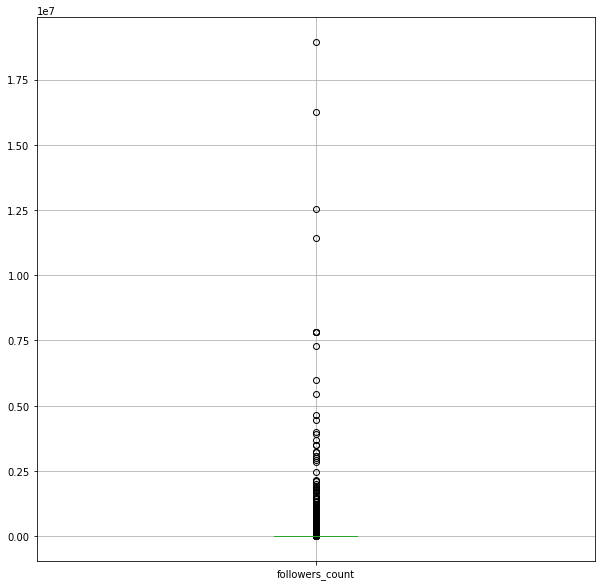

In [26]:
followers = tweets.select('user.followers_count')
f = followers.toPandas()
f.boxplot(column = 'followers_count',figsize = (10,10))

In [27]:
f.describe()

,followers_count
count,1.000000e+05
mean,4.989933e+03
std,1.271756e+05
min,0.000000e+00
25%,1.520000e+02
50%,3.720000e+02
75%,8.150000e+02
max,1.893753e+07


+ From the summary above, we could see that the followers_count has really large standard deviation. Since the mean is even larger than the mean and based on the boxplot, we could say the distribution of the followers_count is skewed to the right.
+ From the describe table of followers_count, we could see that even 75th percentile is still smaller than mean. 
+ Based on the boxplot above, there is a obvious split at round 250,000. The outliers over 250,000 are more scattered.

In [28]:
tweets.filter('user.followers_count > 250000').count()

293

In [24]:
tweets.filter('user.followers_count < 5').count()

1163

+ After using the pipeline, I found that there are 293 users that have followers_count larger than 250,000. I therefore decide to take the top 300 as the 'many'.
+ As for 'few' users, it is not meaningful to use 25th percentile - 1.5*IQR to find outlier because we will get a negative return. Therefore, I directly pick 5 as a reference. It turns out that 2114 users have less then 10 followers which is about 1% of the total. 

__Section 2: hastags__

In [11]:
hash_many = tweets.filter('user.followers_count > 250000').select('entities.hashtags').rdd
hash_many2 = tweets.filter('user.followers_count > 250000').select('entities.hashtags')

In [25]:
hash_few = tweets.filter('user.followers_count < 5').select('entities.hashtags').rdd

In [25]:
hash_many2.printSchema()

root
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)



__Many__:

In [21]:
hash_many.flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(10, key=lambda pair: -pair[1])

[('WorldSeries', 70),
 ('Astros', 36),
 ('EarnHistory', 34),
 ('SerieMundial', 10),
 ('Dodgers', 9),
 ('ThisTeam', 9),
 ('Houston', 5),
 ('smESPN', 4),
 ('worldseries', 3),
 ('Game5', 3)]

__Few:__

In [26]:
hash_few.flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(10, key=lambda pair: -pair[1])

[('EarnHistory', 134),
 ('WorldSeries', 129),
 ('Astros', 78),
 ('HR4HR', 48),
 ('Dodgers', 35),
 ('ThisTeam', 28),
 ('worldseries', 24),
 ('WorldSeries2017', 23),
 ('ASTROSWIN', 22),
 ('astros', 19)]

__Simiarity:__
+ We could see that both the many and few are mainly focused about Baseball. EarnHistory, WorldSeries, Dodgers, Astros are listed in top 5 for both results.
+ The case of hastag also affects. In both many and few results, WorldSeries is ranked higher than worldseries. I might want to recommend the twitter user to standardize the case of hastag. This might increase the followers number.

__Difference:__
+ The hashtags for the few groups are more specifed or personal preferenced. Such as ASTROSWIN, rather than taging Astro, this hashtag shows the users strong preference. Also WorldSeries2017, this hashtag has the year added instead of using WorldSeries. 
+ HR4HR is a hashtag for HR community. HR accounts might not be very attractive to gain more followers on Tweet.

### Q3.5 - Analyze common words in tweet text

Following the example in class, use `tweets.rdd` to find the most common interesting words in tweet text.  To keep it "interesting", add a filter that removes at least 10 common stop words found in tweets, like "a", "an", "the", and "RT" (you might want to derive these stop words from initial results).  To split lines into words, a simple split on text whitespace like we had in class is sufficient; you do not have to account for punctuation.

After you find the most common words, use dataframe or SQL queries to find patterns among how those words are used.  For example, are they more frequently used by Dodgers or Astros fans, or by people in one part of the country over another?  Explore and see what you can find, and discuss your findings.

Hint: don't forget all the word count pipeline steps we used earlier in class.

**Answer**

In order to find out at least 10 most common stopwords on twitter, I first run a word count and show the top 30 to see what need to be added to the stopword list which later will be excluded.

In [16]:
tweets.rdd.flatMap(lambda r: r['text'].split(' ')) \
    .map(lambda t: (t, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(30, key=lambda pair: -pair[1])

[('RT', 62909),
 ('the', 44143),
 ('Astros', 20546),
 ('in', 19550),
 ('a', 19538),
 ('to', 19389),
 ('', 15698),
 ('@astros:', 15407),
 ('Dodgers', 13876),
 ('#WorldSeries', 11306),
 ('of', 11009),
 ('#EarnHistory', 10296),
 ('The', 10231),
 ('@astros', 9924),
 ('is', 9342),
 ('win', 9250),
 ('I', 9164),
 ('game', 9088),
 ('and', 8818),
 ('this', 8723),
 ('for', 8646),
 ('THE', 7434),
 ('World', 6315),
 ('Game', 6191),
 ('#Astros', 6004),
 ('that', 5939),
 ('was', 5868),
 ('on', 5831),
 ('5', 5501),
 ('Series', 5500)]

+ From the result, I might want to those words that are not meaning for comparsion:
__['RT','the','in','a','to', '', 'of','is','I','and','this','that','for','was','on','The'].__
+ I then will rerun the previous steps and adding a filter that exclude those words.

In [19]:
stop = ['RT','the','in','a','to', '', 'of','is','I','and','this','that','for','was','on','The']
tweets.rdd.flatMap(lambda r: r['text'].split(' ')) \
    .filter(lambda t: t not in stop) \
    .map(lambda t: (t, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(30, key=lambda pair: -pair[1])

[('Astros', 20546),
 ('@astros:', 15407),
 ('Dodgers', 13876),
 ('#WorldSeries', 11306),
 ('#EarnHistory', 10296),
 ('@astros', 9924),
 ('win', 9250),
 ('game', 9088),
 ('THE', 7434),
 ('World', 6315),
 ('Game', 6191),
 ('#Astros', 6004),
 ('5', 5501),
 ('Series', 5500),
 ('@Dodgers', 5434),
 ('it', 5262),
 ('@ABREG_1', 5239),
 ('are', 4988),
 ('just', 4859),
 ('one', 4840),
 ('3-2', 4514),
 ('A', 4266),
 ('you', 4260),
 ('ASTROS', 4233),
 ('IT', 4128),
 ('This', 4059),
 ('BREGMAN', 3788),
 ('lead', 3751),
 ('de', 3718),
 ("LET'S", 3603)]

__WorldSeries by different region of the countries:__
+ From the result we could see that central time zone has the highest mentions on 'WorldSeries'. Pacific Time is ranked the second which is slightly lower then Central Time.
+ Eastern time is ranked the 3rd. But it is much lower than the first two region.
+ The rest of the time zones have much lower mentions of 'WorldSeries', all lower than 500.
+ I could conclude that Central Time and Pacific time zone has the most interest in Baseball based on 'WorldSeries' mention. Eastern time zone has also lots of interest in Baseball but not that much as the previous two. The rest region is not that focus on baseball.

In [44]:
tweets.filter(tweets['text'].contains('WorldSeries')) \
    .groupby('user.time_zone') \
    .count() \
    .orderBy('count',ascending = False) \
    .show(10,False)

+---------------------------+-----+
|time_zone                  |count|
+---------------------------+-----+
|null                       |6409 |
|Central Time (US & Canada) |2796 |
|Pacific Time (US & Canada) |2608 |
|Eastern Time (US & Canada) |1568 |
|Mountain Time (US & Canada)|348  |
|Arizona                    |335  |
|Atlantic Time (Canada)     |196  |
|Quito                      |133  |
|Hawaii                     |107  |
|Mexico City                |105  |
+---------------------------+-----+
only showing top 10 rows



__WorldSeries mentioned by Astros fans:__
+ I here define Astro fans as those tweet users who have 'Astros' in their hashtags.

In [53]:
tweets.select('entities.hashtags').rdd \
    .flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .filter(lambda r: 'Astros' in r) \
    .reduceByKey(lambda a, b: a + b).take(1)

[('Astros', 6736)]

In [54]:
tweets.filter(tweets['text'].contains('WorldSeries')) \
    .select('entities.hashtags').rdd \
    .flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .filter(lambda r: 'Astros' in r) \
    .reduceByKey(lambda a, b: a + b).take(1)

[('Astros', 2848)]

In [55]:
2848/6736

0.42280285035629456

__WorldSeries mentioned by Dodgers fans:__
+ I here define Dodgers fans as those tweets users who have 'Dodgers' in their hashtags.

In [56]:
tweets.select('entities.hashtags').rdd \
    .flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .filter(lambda r: 'Dodgers' in r) \
    .reduceByKey(lambda a, b: a + b).take(1)

[('Dodgers', 3638)]

In [57]:
tweets.filter(tweets['text'].contains('WorldSeries')) \
    .select('entities.hashtags').rdd \
    .flatMap(lambda r:r).flatMap(lambda r:r).map(lambda r: (r['text'],1)) \
    .filter(lambda r: 'Dodgers' in r) \
    .reduceByKey(lambda a, b: a + b).take(1)

[('Dodgers', 1400)]

In [58]:
1400/3638

0.38482682792743267

__Comparison of WorldSeries mentioned by Dodgers and Astros fans:__
+ For both of the Dodgers and Astros fans, less of half of the fans mentioned about 'WorldSeries' that might implies only less than half of the fans actually care about the championship games of their supporting teams for both Dodgers and Astros.
+ The mentioned rate of Astros is 42.28% and 38.48% for Dodgers fans. Astros fans are slightly more reactive about WorldSeies than Dodgers fan.